**Chapter 6: Enhancing and Segmenting Images**
# Super-Resolution with Deep Auto-Encoders

So far in previous notebooks, we applied shallow fully-connected auto-encoders to synthetic problems. It is now time to experiment with some of the more advanced architectures presented in Chapter 6. For that, we also need a more challenging task. 

Therefore, we will implement a standard **_deep auto-encoder (DAE)_** and use it to improve the resolution of downsampled images. This task, called **_image super-resolution_**, can be considered as a variant of _image denoising_. Here, the model should remove the artifacts caused by the downsampling, and try to recover some details lost in the process.

In a second time, we will implement our own **_U-Net_** model from scratch, and compare its performance with our first solution. 

In [1]:
import os
import tensorflow as tf
import numpy as np

seed = 42 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(seed)

os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In the following experiment, we will try to **up-scale images with the following factor**:

In [2]:
scale_factor = 4

## Preparing the Dataset

To make the task more interesting, we will use this time proper pictures, from the [COCO](http://cocodataset.org) dataset[$^1$](#ref) (c.f. Chapter 5).

More specifically, we will build an input pipeline to train our model to up-sample images of _living-rooms_. As mentioned in the book, it is actually difficult to train models for super-resolution, and they usually only shine when they are **trained and applied to specific categories** of images (i.e., images with some common features that the CNN can learn to exploit). So... let us imagine that we are for instance building a model to improve low-quality images from a company specialized in interior design...

### COCO dataset and API

To handle the dataset, we will use the API provided by its authors: [`pycocotools`](https://github.com/cocodataset/cocoapi).

As mentioned in their Github, the images and annotations should first be downloaded (see [here](http://cocodataset.org/#download)). For this experiment, we used the "2014 Train/Val" dataset. The archives should then be unzipped in `cocoapi/images` and `cocoapi/annotations` folders.

Once done, the API can be used as follow:

In [3]:
# !pip install pycocotools # uncomment to install this module

In [4]:
from pycocotools.coco import COCO

# Adapt to your setup:
COCO_API_FOLDER = os.path.expanduser('~/code/cocoapi')
COCO_TRAIN = 'train2014'
COCO_VAL = 'val2014'

train_img_folder = os.path.join(COCO_API_FOLDER, 'images', COCO_TRAIN)
val_img_folder = os.path.join(COCO_API_FOLDER, 'images', COCO_VAL)

train_anno_file = os.path.join(
    COCO_API_FOLDER, 'annotations', 'instances_{}.json'.format(COCO_TRAIN))
val_anno_file = os.path.join(
    COCO_API_FOLDER, 'annotations', 'instances_{}.json'.format(COCO_VAL))


# Initializing COCO API:
train_coco = COCO(train_anno_file)
val_coco = COCO(val_anno_file)

loading annotations into memory...
Done (t=8.90s)
creating index...
index created!
loading annotations into memory...
Done (t=3.73s)
creating index...
index created!


Note that COCO contains RGB images of **different size**. Furthermore, we want to try a model
 able to up-scale images whatever their original dimensions.

Therefore, since our images will have different sizes, we cannot batch them. Hence a batch size of 1:

In [5]:
batch_size = 1

num_channels = 3
num_epochs = 50

### Image selection for the task

Back to the dataset. COCO images have dense annotations, and with this API, it is possible to select images based on which classes they contain. Let us list all these categories:

In [6]:
coco_categories = train_coco.loadCats(train_coco.getCatIds())
coco_labels = [cat['name'] for cat in coco_categories]
print('\033[1mCOCO categories:\033[0m\n{}'.format(', '.join(coco_labels)))

COCO categories:
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush


We will use these categories to shortlist our living-room images. It is not an exact art, but we could do this short-listing by selectioning images which contain objects commonly found together in living rooms... Like a couch and chairs, or couch and potted plants, couch and tv, tv and chairs, etc.:

In [7]:
categories = [['couch', 'chair'], ['couch', 'potted plant'], ['couch', 'tv']]

Then we can use the API to short-list our images accordingly:

In [8]:
def get_image_files_per_categories(coco, categories, image_folder):
        
    # Getting all images labeled with the given categories:
    category_ids = coco.getCatIds(catNms=categories)
    image_ids = coco.getImgIds(catIds=category_ids)
    images = coco.loadImgs(image_ids)
    
    # Getting their filenames:
    image_filenames = [os.path.join(image_folder, img['file_name']) for img in images]
    
    return image_filenames

In [9]:
# Listing images containing these combinations of categories:
train_files, val_files = [], []
for cat_combination in categories:
    train_cat_files = get_image_files_per_categories(
        train_coco, cat_combination, train_img_folder)
    val_cat_files = get_image_files_per_categories(
        val_coco, cat_combination, val_img_folder)
    print("Number of images for categories {}: {} train ; {} val.".format(
        cat_combination, len(train_cat_files), len(val_cat_files)))
    train_files += train_cat_files
    val_files += val_cat_files

# Removing images appearing multiple times:
train_files = sorted(list(set(train_files)))
val_files   = sorted(list(set(val_files)))

print("\nTotal number of unique images : {} train ; {} val.".format(
    len(train_files), len(val_files)))

Number of images for categories ['couch', 'chair']: 1568 train ; 668 val.
Number of images for categories ['couch', 'potted plant']: 670 train ; 303 val.
Number of images for categories ['couch', 'tv']: 909 train ; 419 val.

Total number of unique images : 2017 train ; 887 val.


This is not exactly a big dataset to train on, and there is no certaintythat all the images are reall the _interior design_ kind, but this will do for our experiment.

We visualize a sample:

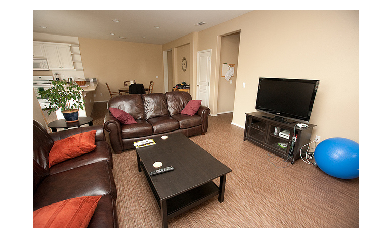

In [10]:
# !pip install scikit-image # <-- uncomment to install skimage with pip
import skimage.io as io
import matplotlib.pyplot as plt

random_img_file = np.random.choice(train_files, size=1)[0]
random_img = io.imread(random_img_file)
plt.axis('off')
plt.imshow(random_img)
plt.show()

### Input pipeline with `tf.data`

We have our dataset, we can now set up the input pipeline. As we did in previous chapters, we will use `tf.data` to serve training/validation batches to our model. Copied from previous notebooks, the pipeline below does the following:

- It takes the list of image files and iterate over them batch after batch;
- Given an image file, it opens and parses the image as a tensor;
- It randomly augments the image (random change of brightness/saturation, random cropping/scaling, etc.);
- It duplicates the image and downscales one (**the downscaled image will be our model's input, the original one the target**);
- It batches the images together (if `batch_size > 1`) and repeat the process for `num_epochs`.

In [11]:
import functools

def _augmentation_fn(image):
    """
    Apply random transformations to augment the training images.
    :param images:      Images
    :return:            Augmented Images
    """

    # Randomly applied horizontal flip:
    image = tf.image.random_flip_left_right(image)

    # Random B/S changes:
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

    # Random resize and random crop back to expected size:
    original_shape = tf.shape(image)
    random_scale_factor = tf.random_uniform([1], minval=1.0, maxval=1.3, dtype=tf.float32)
    scaled_height = tf.cast(tf.multiply(tf.to_float(original_shape[0]), random_scale_factor), tf.int32)
    scaled_width = tf.cast(tf.multiply(tf.to_float(original_shape[1]), random_scale_factor), tf.int32)
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
    image = tf.image.resize_images(image, scaled_shape)
    image = tf.image.random_crop(image, original_shape)

    return image


def parse_function(filename, scale_factor=4, augment=True):
    
    # Reading the file and returning its content as bytes:
    image_string = tf.read_file(filename)
    # Decoding those into the image 
    # (with `channels=3`, TF will duplicate the channels of grayscale images so they have 3 channels too):
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Converting to float:
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    
    # Opt. augmenting the image:
    if augment:
        image = _augmentation_fn(image)
    
    # Generating the data pair for super-resolution task, 
    # i.e. the downscaled image + its original version
    original_size = tf.shape(image)[:2]
    scaled_size = original_size // scale_factor
    image_downscaled = tf.image.resize_images(image, scaled_size)
    
    # Just in case the original dimensions were not a multiple of `scale_factor`,
    # we slightly resize the original image so its dimensions now are
    # (to make the loss/metrics computations easier during training):
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize_images(image, original_size_mult)
    
    return image_downscaled, image


def coco_superres_input_fn(
        image_files, scale_factor=4,
        shuffle=False, batch_size=32, num_epochs=None, augment=False,
        seed=None):

    # Converting to TF dataset:
    image_files = tf.constant(image_files)
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, seed=seed)
    dataset = dataset.prefetch(1)
    
    # Batching + adding parsing operation:
    parse_fn = functools.partial(parse_function, 
                                 scale_factor=scale_factor,
                                 augment=augment)
    dataset = dataset.map(parse_fn, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
        
    dataset = dataset.repeat(num_epochs)    
    return dataset

We now initialize our training and validation input pipelines accordingly:

In [12]:
train_steps_per_epoch = len(train_files) // batch_size
val_steps_per_epoch = len(val_files) // batch_size

train_dataset = coco_superres_input_fn(
    train_files, scale_factor=scale_factor, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=seed)
val_dataset = coco_superres_input_fn(
    val_files, scale_factor=scale_factor, batch_size=batch_size,
    shuffle=True, num_epochs=None, augment=False, seed=seed)
    # normally we wouldn't shuffle the validation dataset
    # (it is a costly operation, with no effect on the validation results),
    # but we will also use this dataset to render some random results... 
    
train_iterator = train_dataset.make_one_shot_iterator()
train_images_downscaled, train_images_orig = train_iterator.get_next()
val_iterator = val_dataset.make_one_shot_iterator()
val_images_downscaled, val_images_orig = val_iterator.get_next()

session = tf.Session()

Let us make sure our pipelines are working as expected, by visualizing some batches. For a one-on-one comparison and to better measure the effect of the downsampling, we use TensorFlow to re-scale the images back to their original dimensions.

/home/benjamin/anaconda3/envs/main/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


PSNR for each pair: [21.2108, 25.598093, 23.688517]


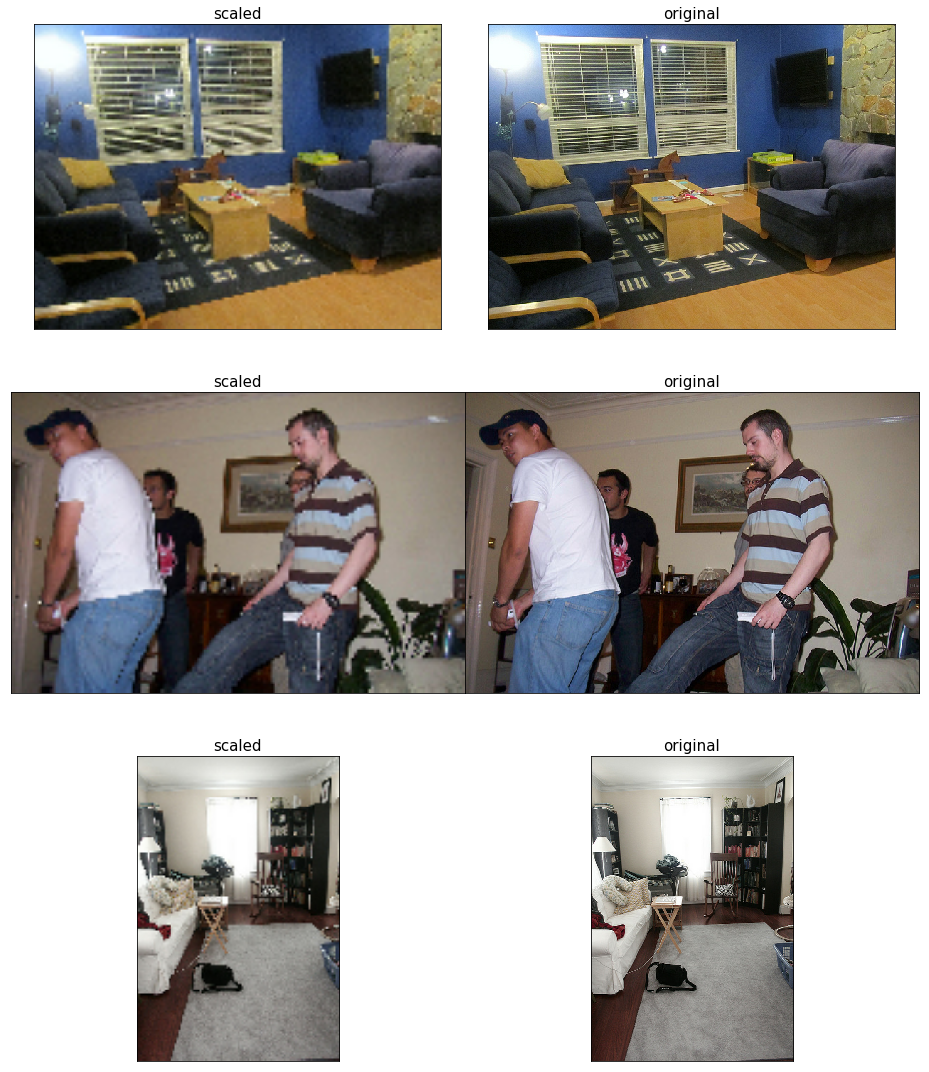

In [13]:
from plot_utils import plot_image_grid

num_show = 3

# Resizing the image back with default method to show the artifacts it causes:
val_images_scaledback = tf.image.resize_images(val_images_downscaled, 
                                               tf.shape(val_images_orig)[1:3])
val_psnr_result = tf.image.psnr(val_images_orig, val_images_scaledback, max_val=1.)

input_samples, target_samples, psnr_samples = [], [], []
while len(input_samples) < num_show:
    batch_image, batch_target, psnr_val = session.run(
        [val_images_scaledback, val_images_orig, val_psnr_result])
    # (our batch size is 1, the returned elements are not batched)
    input_samples.append(batch_image[0])
    target_samples.append(batch_target[0])
    psnr_samples.append(psnr_val[0])

# Displaying some examples:
input_samples, target_samples = input_samples[:num_show], target_samples[:num_show]
figure = plot_image_grid([input_samples, target_samples],
                         titles=["scaled", "original"])
figure.show()

psnr_val = psnr_val[0]
print("PSNR for each pair: {}".format(psnr_samples[:num_show]))

In [14]:
# We will use the 1st of the 3 images, to log in Tensorboard:
id_image_for_tensorbaord = 0

First of all, it appears this dataset has _lots_ of pictures of people playing video games in their living room... Not all the pictures we selected seem relevant to our use-case example, but let us still proceed.
Second, we can clearly see the upscaling artifacts / missing details in the tampered images, as confirmed by their low PSNR. For later comparison, let us compute the average PSNR for the whole validation dataset:

In [15]:
for i in range(1, len(val_files)):
    psnr_val += session.run(val_psnr_result)[0]
psnr_val = psnr_val / len(val_files)
print("Avg PSNR using default `tf.image.resize_images()` to scale up val images: {}".format(psnr_val))

Avg PSNR using default `tf.image.resize_images()` to scale up val images: 24.106466230975197


The task of our model will be therefore to recover some of the details in the _corrupted_ images (and achieve a better PSNR, i.e., above **~24.1dB**).

## Building and Training a Deep Auto-Encoder

In the following section, we will build our first convolutional auto-encoder, which will allow us to efficiently process images, whatever their dimensions.

## Convolutional Auto-Encoder

As usual, we will stick with the Keras API to implement our model, though our readers are welcome to try reimplementing everything, e.g., using `tf.layers`.

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose

As already mentioned in the chapter and in this notebook, we will tackle image super-resolution with an auto-encoder, similar to how we dealt with image denoising. 

Therefore, the idea is to **first use some standard algorithm to scale our downsample input back to its original shape** (e.g., using _bilinear interpolation_), before feeding it to our model. Like in the previous notebook, the task of our model is then to recover the _corrupted_ image, i.e., to remove the artifacts caused by the standard upsacling and to recover some details lost with the downsampling (c.f. images above). This way our model can be trained with minimal supervision (c.f. chapter), simply computing a loss between its outputs and the original images.
Once trained, our model could be used along  this standard upscaling algorithm, to improve the result quality.

Concretely, we thus add to our model a first layer which upscales the downsampled input images back to their original shape (using bilinear interpolation implemented by `tf.image.resize_images()`):

In [17]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize_images(images, 
                                          tf.shape(images)[1:3] * scale_factor), 
    name=name)

Then we build the **encoder** and **decoder** parts of our model, **using standard and transposed convolutions**.

In [18]:
def simple_dae(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    """
    Build a simple fully-convolutional DAE network.
    :param inputs:        Input tensor/placeholder
    :param kernel_size:   Kernel size for the convolutions
    :param filters_orig:  Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:   Number of layers composing the encoder/decoder
    :return:              DAE network (Keras Functional API)
    """

    # Encoding layers:
    filters = filters_orig
    x = inputs
    for i in range(layer_depth):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   activation='relu', strides=2, padding='same',
                   name='enc_conv{}'.format(i))(x)
        filters = min(filters * 2, 512)

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                            activation='relu', strides=2, padding='same',
                            name='dec_deconv{}'.format(i))(x)
    decoded = Conv2D(filters=num_channels, kernel_size=1,
                     activation='sigmoid', padding='same',
                     name='dec_output')(x)
    # note: we use a sigmoid for the last activation, as we want the output values
    # to be between 0 and 1, like the input ones.
    
    return decoded

To have a look how it would process a given image, let us instantiate our network for a fixed input size, and print its summary:

In [19]:
inputs_fixed = Input(shape=(91, 91, num_channels), name='input')

outputs = simple_dae(inputs_fixed, kernel_size=4, filters_orig=32, layer_depth=4)

autoencoder_example = Model(inputs_fixed, outputs)
autoencoder_example.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

del autoencoder_example

_________________________________________________________________
Layer (type)          Output Shape        Param 
input (InputLayer)    (None, 91, 91, 3)   0     
_________________________________________________________________
enc_conv0 (Conv2D)    (None, 46, 46, 32)  1568  
_________________________________________________________________
enc_conv1 (Conv2D)    (None, 23, 23, 64)  32832 
_________________________________________________________________
enc_conv2 (Conv2D)    (None, 12, 12, 128) 131200
_________________________________________________________________
enc_conv3 (Conv2D)    (None, 6, 6, 256)   524544
_________________________________________________________________
dec_deconv0 (Conv2DTr (None, 12, 12, 256) 104883
_________________________________________________________________
dec_deconv1 (Conv2DTr (None, 24, 24, 128) 524416
_________________________________________________________________
dec_deconv2 (Conv2DTr (None, 48, 48, 64)  131136
_______________________________

As we can see, our network indeed follows the encoder-decoder paradigm. The encoder extracts features, reducing the spatial dimensionality of the image layer after layer. Reciprocally, the decoder attempts to recover the original dimensions and content.


However, we can also observe that, when the dimensions of our images are not normalized/not even, it is possible that, after downsampling and upsampling through the encoder/decoder, we do **not obtain the exact original size** (with a difference of $\pm 1$px).
To avoid the problems this may cause (when computing the loss comparing outputs and targets), we define a layer to slightly resize the generated image to the target dimensions:

In [20]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize_images(images[0], tf.shape(images[1])[1:3]), 
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)

Combining everything together, we build our network for image super-resolution:

In [21]:
def simple_dae_for_super_resolution(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    """
    Build a simple fully-convolutional DAE network.
    :param inputs:        Input tensor/placeholder
    :param kernel_size:   Kernel size for the convolutions
    :param filters_orig:  Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:   Number of layers composing the encoder/decoder
    :return:              DAE network (Keras Functional API)
    """
    
    # To have a symmetrical auto-encoder, we up-sample the input images to 
    # their target dimensions, using the default interpolation up-scaling.
    # The task of the auto-encoder will be to remove the artifacts/noise caused by
    # this default operation.
    resized_inputs = Upscale(name='upscale_input')(inputs)
    
    decoded = simple_dae(resized_inputs, kernel_size, filters_orig, layer_depth)
    
    # We take care of the aforementioned edge-case:
    decoded = ResizeToSame(name='dec_output_scale')([decoded, resized_inputs])
    
    return decoded

We can now instantiate our model:

In [22]:
# Network hyper-parameters:
kernel_size = 4
filters_orig = 32
layer_depth = 4

In [23]:
# Image size will vary. Therefore, we use `None` for the variable dimensions:
inputs = Input(shape=(None, None, num_channels), name='input')

decoded = simple_dae_for_super_resolution(inputs, kernel_size, filters_orig, layer_depth)

# Auto-encoder model:
autoencoder = Model(inputs, decoded)
autoencoder.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

__________________________________________________________________________________________________
Layer (type)                      Output Shape                 Param #   Connected to             
input (InputLayer)                (None, None, None, 3)        0                                  
__________________________________________________________________________________________________
upscale_input (Lambda)            (None, None, None, 3)        0         input[0][0]              
__________________________________________________________________________________________________
enc_conv0 (Conv2D)                (None, None, None, 32)       1568      upscale_input[0][0]      
__________________________________________________________________________________________________
enc_conv1 (Conv2D)                (None, None, None, 64)       32832     enc_conv0[0][0]          
__________________________________________________________________________________________________
enc_conv2 

Since our model is **fully-convolutional** and not so deep, its number of trainable parameters is rather low, which will simplify the training.

### Training

Reusing the **custom metrics and callbacks** defined in the previous notebooks, we train our model: 

In [24]:
import functools
import collections
from keras_custom_callbacks import TensorBoardImageGridCallback, SimpleLogCallback

optimizer = tf.keras.optimizers.Adam()

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

model_dir = './models/superres_dae'
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("val-loss", "val_loss"),
                                            ("psnr", "psnr"), ("val-psnr", "val_psnr")])

callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, 
        input_images=np.expand_dims(input_samples[id_image_for_tensorbaord], 0), 
        target_images=np.expand_dims(target_samples[id_image_for_tensorbaord], 0), 
        tag='ae_super_res_results', figsize=(15, 15)),
    # Callback to print compacted metrics at the end of each epoch:
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)
]

autoencoder.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric])

history_ae = autoencoder.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/50: loss = 0.083; val-loss = 0.076; psnr = 19.073; val-psnr = 19.328
Epoch  1/50: loss = 0.073; val-loss = 0.074; psnr = 19.852; val-psnr = 19.365
Epoch  2/50: loss = 0.070; val-loss = 0.073; psnr = 20.075; val-psnr = 19.479
Epoch  3/50: loss = 0.069; val-loss = 0.073; psnr = 20.160; val-psnr = 19.428
Epoch  4/50: loss = 0.069; val-loss = 0.072; psnr = 20.201; val-psnr = 19.466
Epoch  5/50: loss = 0.068; val-loss = 0.077; psnr = 20.191; val-psnr = 19.144
Epoch  6/50: loss = 0.067; val-loss = 0.072; psnr = 20.291; val-psnr = 19.513
Epoch  7/50: loss = 0.057; val-loss = 0.058; psnr = 21.368; val-psnr = 20.892
Epoch  8/50: loss = 0.048; val-loss = 0.054; psnr = 22.319; val-psnr = 21.164
Epoch  9/50: loss = 0.047; val-loss = 0.053; psnr = 22.443; val-psnr = 21.241
Epoch 10/50: loss = 0.047; val-loss = 0.053; psnr = 22.507; val-psnr = 21.258
Epoch 11/50: loss = 0.046; val-loss = 0.052; psnr = 22.548; val-psnr = 21.362
Epoch 12/50: loss = 0.046; val-loss = 0.051; ps

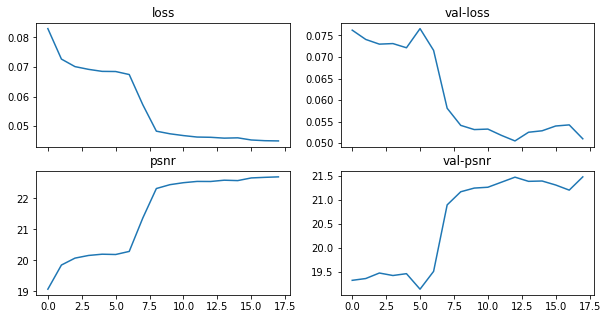

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

ax[0, 0].plot(history_ae.history['loss'])
ax[0, 1].plot(history_ae.history['val_loss'])
ax[1, 0].plot(history_ae.history['psnr'])
ax[1, 1].plot(history_ae.history['val_psnr'])

As expected, our model converged rather fast, but its performance is quite disappointing. With an avarage PSNR of **~21.8dB** on the validation images, we are far below the PSNR of **~24.1dB** when purely using bilinear interpolation to upscale them. Even the metric on the training images stayed below. In terms of PSNR, our model makes things worse... 

**Note:** PSNR is not an absolute measure of image quality, only evaluating how bad the noise is. Images with the same PSNR may have different _**perceptual quality**_ to human eyes (e.g., an image may have some heavy noise, but only in regions which do not contain _salient_ details and therefore not really affecting the perceived quality). Evaluating the perceptual quality of images is still an open problem, 

Thanks to our custom callback, we could already observe some results in Tensorboard (console command `tensorboard --logdir ./models` then [http://localhost:6006/#images](http://localhost:6006/#images)). Still, let us draw some results here:

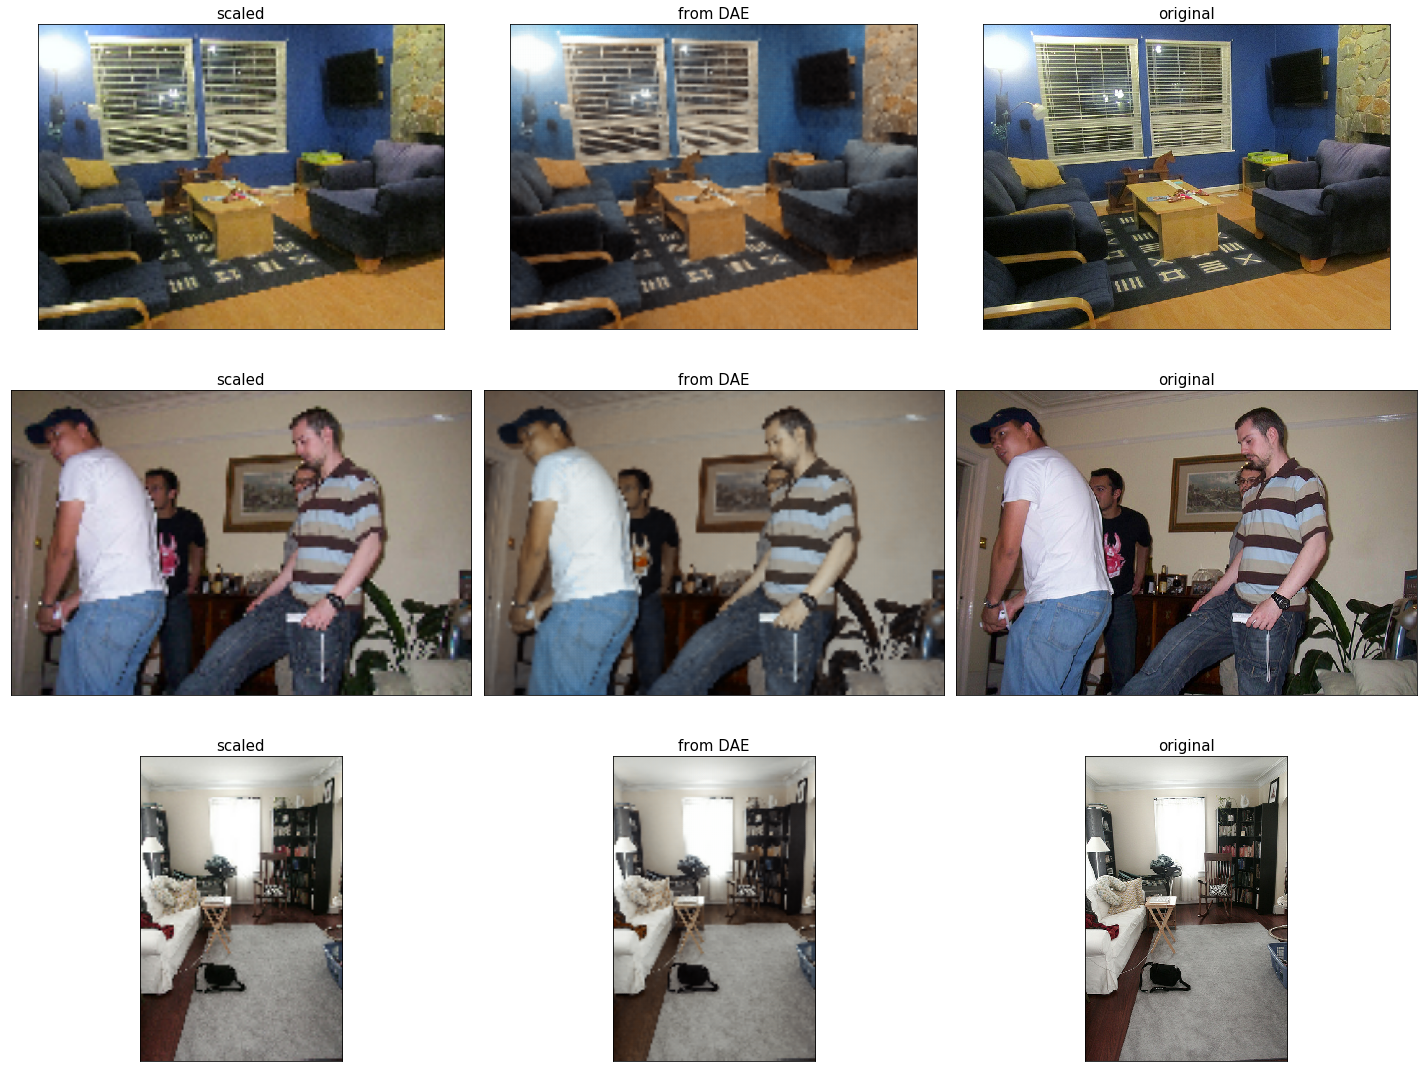

In [26]:
num_show = 3

output_samples = []
for i in range(num_show):
    # Predicting on a single input image:
    output = autoencoder.predict(input_samples[i][None, ...])[0]
    output_samples.append(output)

figure = plot_image_grid([input_samples, output_samples, target_samples], 
                         titles=["scaled", "from DAE", "original"])
figure.show()

As we can see, the network did its best to soften the sampling artifacts, but images are instead left blurry. We can also notice that colors are sometimes altered. All in all, our images do not look better indeed...

## Building and Training a U-Net

We will try to do better. In Chapter 6, we presented some more advanced encoder-decoder architecture. It is time to re-implement and apply one of them. In the following section, we will therefore build our own **_U-Net_**[$^2$](#ref) and apply it to image super-resolution.

### U-Net architecture

Most of the problems with our previous model can be attributed to the **network's bottleneck**. Because of its architecture, our model has to find ways to compress the information, and the decoder only receives this lower-dimensional input to condition its reconstruction. If an image contains unusual features (e.g., unusual objects or colors), the encoder will not properly compress them, and the decoder won't have any other inputs to recover these approximations.

_U-Net_[$^2$](#ref) has a straightforward solution to this problem: it adds a **skip/shortcut** connection between pairs of encoding/decoding blocks. Therefore, each decoding block is not only conditioned by the rich-yet-low-dimensional features coming from the previous block, but also by the less-coarse map from the parallel encoding block. In other words, the decoding blocks are **provided with both the contextual information** from the preceding block, **and with the location information** from the encoding path.

As a quick reminder from the chapter, this is the U-Net architecture:

![U-Net Architecture](./notebook_images/unet.png)

**Note:** **batch normalization** and **dropout** layers are not represented here. Typically, each convolutional layer (`conv` in  the figure) actually does the following here: _convolution_, (opt.) _batch normalization_, _activation_. Furthermore, the **_Leaky ReLU_** function is commonly used as activation, instead of the standard _ReLU_. Introduced by Kaiming He et al.[$^3$](#ref), this _LReLU_ allows a small negative slopes for negative values, solving potential gradient problems (see paper for details[$^3$](#ref))

To reimplement this architecture, let us go bottom-up. We will start by writing a function wrapping the operations actually done by `conv`, then another wrapping each block of two `conv` together:

In [27]:
from tensorflow.keras.layers import (
    Dropout, MaxPooling2D, LeakyReLU, concatenate, BatchNormalization)


def name_layer_factory(num=0, name_prefix="", name_suffix=""):
    """
    Helper function to name all our layers.
    """
    def name_layer_fn(layer):
        return '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)
    
    return name_layer_fn


def conv_bn_lrelu(filters, kernel_size=3, batch_norm=True,
                  kernel_initializer='he_normal', padding='same',
                  name_fn=lambda layer: "conv_bn_lrelu-{}".format(layer)):
    """
    Return a function behaving like a sequence convolution + BN + lReLU.
    :param filters:              Number of filters for the convolution
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param kernel_initializer:   Name of kernel initialization method
    :param padding:              Name of padding option
    :param name_fn:              Function to name each layer of this sequence
    :return:                     Function chaining layers
    """
    
    def block(x):
        x = Conv2D(filters, kernel_size=kernel_size, 
                   activation=None, kernel_initializer=kernel_initializer, 
                   padding=padding, name=name_fn('conv'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
        return x
    
    return block


def unet_conv_block(filters, kernel_size=3,
                    batch_norm=True, dropout=False, 
                    name_prefix="enc_", name_suffix=0):
    """
    Return a function behaving like a U-Net convolution block.
    :param filters:              Number of filters for the convolution
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param dropout:              NFlag to perform dropout between the two convs
    :param name_prefix:          Prefix for the layer names
    :param name_suffix:          FSuffix for the layer names
    :return:                     Function chaining layers
    """
    
    def block(x):
        # First convolution:
        name_fn = name_layer_factory(1, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(1, name_prefix, name_suffix))(x)
        if dropout:
            x = Dropout(0.2, name=name_fn('drop'))(x)

        # Second convolution:
        name_fn = name_layer_factory(2, name_prefix, name_suffix)
        x = conv_bn_lrelu(filters, kernel_size=kernel_size, batch_norm=batch_norm, 
                          name_fn=name_layer_factory(2, name_prefix, name_suffix))(x)

        return x
    
    return block

Now we can chain everything together, according to the architecture presented above. Since we had already reimplemented **_ResNET_** in Chapter 3, there should be nothing really surprising below:

In [28]:
# As the dimensions of our images are not normalized, and often not even, it is
# possible that after downsampling and upsampling, we do not reobtain the original size
# (with a difference of +/- 1px).
# To avoid the problems this may cause, we define a layer to slightly resize the generated
# image to the dimensions of the target one:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize_images(images[0], tf.shape(images[1])[1:3]), 
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)


def unet(x, layer_depth=4, filters_orig=16, kernel_size=3, 
         batch_norm=True, dropout=True, final_activation='sigmoid'):
    """
    Define a U-Net network.
    :param x:                    Input tensor/placeholder
    :param filters_orig:         Number of filters for the 1st CNN layer
    :param kernel_size:          Kernel size for the convolutions
    :param batch_norm:           Flag to perform batch normalization
    :param dropout:              Flag to perform dropout
    :param final_activation:     Name of activation function for the final layer
    :return:                     Network (Keras Functional API)
    """
    
    # Encoding layers:
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        
        # Convolution block:
        x_conv = unet_conv_block(filters, kernel_size, 
                                 dropout=dropout, batch_norm=batch_norm, 
                                 name_prefix="enc_", name_suffix=i)(x)
        
        # We save the pointer to the output of this encoding block,
        # to pass it to its parallel decoding block afterwards:
        outputs_for_skip.append(x_conv)

        # Downsampling:
        x = MaxPooling2D(2)(x_conv)

        filters = min(filters * 2, 512)

    # Bottleneck layers:
    x = unet_conv_block(filters, kernel_size, dropout=dropout, 
                        batch_norm=batch_norm, name_suffix='_btleneck')(x)

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        # Upsampling:
        name_fn = name_layer_factory(3, "ups_", i)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=2, 
                            activation=None, kernel_initializer='he_normal', 
                            padding='same', name=name_fn('convT'))(x)
        if batch_norm:
            x = BatchNormalization(name=name_fn('bn'))(x)
        x = LeakyReLU(alpha=0.3, name=name_fn('act'))(x)
    
        # Concatenation with the output of the corresponding encoding block:
        shortcut = outputs_for_skip[-(i + 1)]
        x = ResizeToSame(name='resize_to_same{}'.format(i))([x, shortcut])
        
        x = concatenate([x, shortcut], axis=-1, name='dec_conc{}'.format(i))

        # Convolution block:
        use_dropout = dropout and (i < (layer_depth - 2))
        x = unet_conv_block(filters, kernel_size, 
                            batch_norm=batch_norm, dropout=use_dropout,
                            name_prefix="dec_", name_suffix=i)(x)

    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out1')(x)  
    # x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', 
    #            padding='same', name='dec_out2')(x)    
    x = Conv2D(filters=num_channels, kernel_size=1, activation=final_activation, 
               padding='same', name='dec_output')(x)
    
    return x

This is it, we reimplemented _U-Net_! As we did with our basic DAE, we instantiate a dummy version with its input size fixed, just for the sake of visualizing how the tensor dimensions evolve through the network:

In [29]:
# Network hyper-parameters:
kernel_size = 4
filters_orig = 32
layer_depth = 4
use_batch_norm = batch_size > 1

In [30]:
inputs_fixed = Input(shape=(91, 91, num_channels), name='input')

outputs = unet(inputs_fixed, layer_depth, filters_orig, kernel_size, 
               use_batch_norm, dropout=False) # no dropout to shorten summary here

unet_example = Model(inputs_fixed, outputs)
unet_example.summary(positions=[.35, .65, .75, 1.]) # `positions` adapts the printed cols' width.

del unet_example

__________________________________________________________________________________________________
Layer (type)                      Output Shape                 Param #   Connected to             
input (InputLayer)                (None, 91, 91, 3)            0                                  
__________________________________________________________________________________________________
enc_conv0-1 (Conv2D)              (None, 91, 91, 32)           1568      input[0][0]              
__________________________________________________________________________________________________
enc_act0-1 (LeakyReLU)            (None, 91, 91, 32)           0         enc_conv0-1[0][0]        
__________________________________________________________________________________________________
enc_conv0-2 (Conv2D)              (None, 91, 91, 32)           16416     enc_act0-1[0][0]         
__________________________________________________________________________________________________
enc_act0-2

Going a bit deeper and duplicating the convolution layers in each encoding/decoding block, our _U-Net_ is heavier than our previous model. Its number of parameters is still decent though. We can also see that while it also has a bottleneck (c.f. its typical U-shaped encoder-decoder architecture), the skip connections allow to circumvent it and pass signals between the encoding and decoding blocks.

### Training

We finally instantiate and train our new model, using the same script as before:

In [35]:
inputs = Input(shape=(None, None, num_channels), name='input')
resized_inputs = Upscale(name='upscale_input')(inputs)

outputs = unet(resized_inputs, layer_depth, filters_orig, kernel_size, use_batch_norm)

unet_model = Model(inputs, outputs)

In [36]:
train_dataset = coco_superres_input_fn(
    train_files, scale_factor=scale_factor, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=seed)
val_dataset = coco_superres_input_fn(
    val_files, scale_factor=scale_factor, batch_size=batch_size,
    shuffle=True, num_epochs=None, augment=False, seed=seed)

optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model_dir = './models/superres_unet'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, 
        input_images=np.expand_dims(input_samples[id_image_for_tensorbaord], 0), 
        target_images=np.expand_dims(target_samples[id_image_for_tensorbaord], 0), 
        tag='unet_super_res_results', figsize=(15, 15)),
    # Callback to print compacted metrics at the end of each epoch:
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)
]


unet_model.compile(optimizer=optimizer, loss='mse', metrics=[psnr_metric])

history_unet = unet_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/50: loss = 0.011; val-loss = 0.014; psnr = 21.579; val-psnr = 18.919
Epoch  1/50: loss = 0.004; val-loss = 0.015; psnr = 25.010; val-psnr = 18.732
Epoch  2/50: loss = 0.003; val-loss = 0.012; psnr = 25.737; val-psnr = 19.679
Epoch  3/50: loss = 0.003; val-loss = 0.012; psnr = 26.012; val-psnr = 19.476
Epoch  4/50: loss = 0.003; val-loss = 0.010; psnr = 26.242; val-psnr = 20.220
Epoch  5/50: loss = 0.003; val-loss = 0.009; psnr = 26.463; val-psnr = 20.786
Epoch  6/50: loss = 0.003; val-loss = 0.008; psnr = 26.695; val-psnr = 21.162
Epoch  7/50: loss = 0.002; val-loss = 0.011; psnr = 26.835; val-psnr = 19.903
Epoch  8/50: loss = 0.002; val-loss = 0.008; psnr = 26.910; val-psnr = 21.181
Epoch  9/50: loss = 0.002; val-loss = 0.008; psnr = 27.004; val-psnr = 21.321
Epoch 10/50: loss = 0.002; val-loss = 0.006; psnr = 27.101; val-psnr = 22.781
Epoch 11/50: loss = 0.002; val-loss = 0.006; psnr = 27.181; val-psnr = 22.688
Epoch 12/50: loss = 0.002; val-loss = 0.006; ps

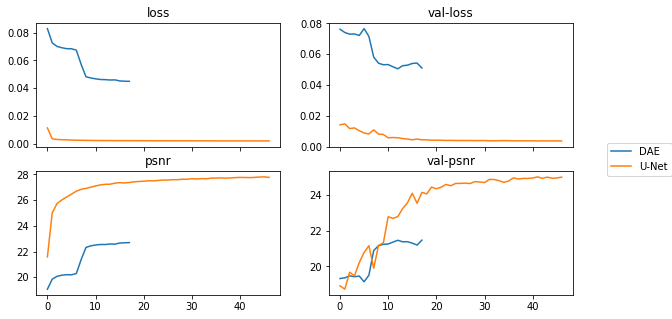

In [37]:
histories = {'DAE': history_ae, 'U-Net': history_unet}

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

lines, labels = [], []
for config_name in histories:
    history = histories[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['psnr'])
    line = ax[1, 1].plot(history.history['val_psnr'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.87)

Metrics look quite better, and it seems our network was able to reduce the sampling noise (c.f. PSNR values > 24.1). Let us visualize here some results:

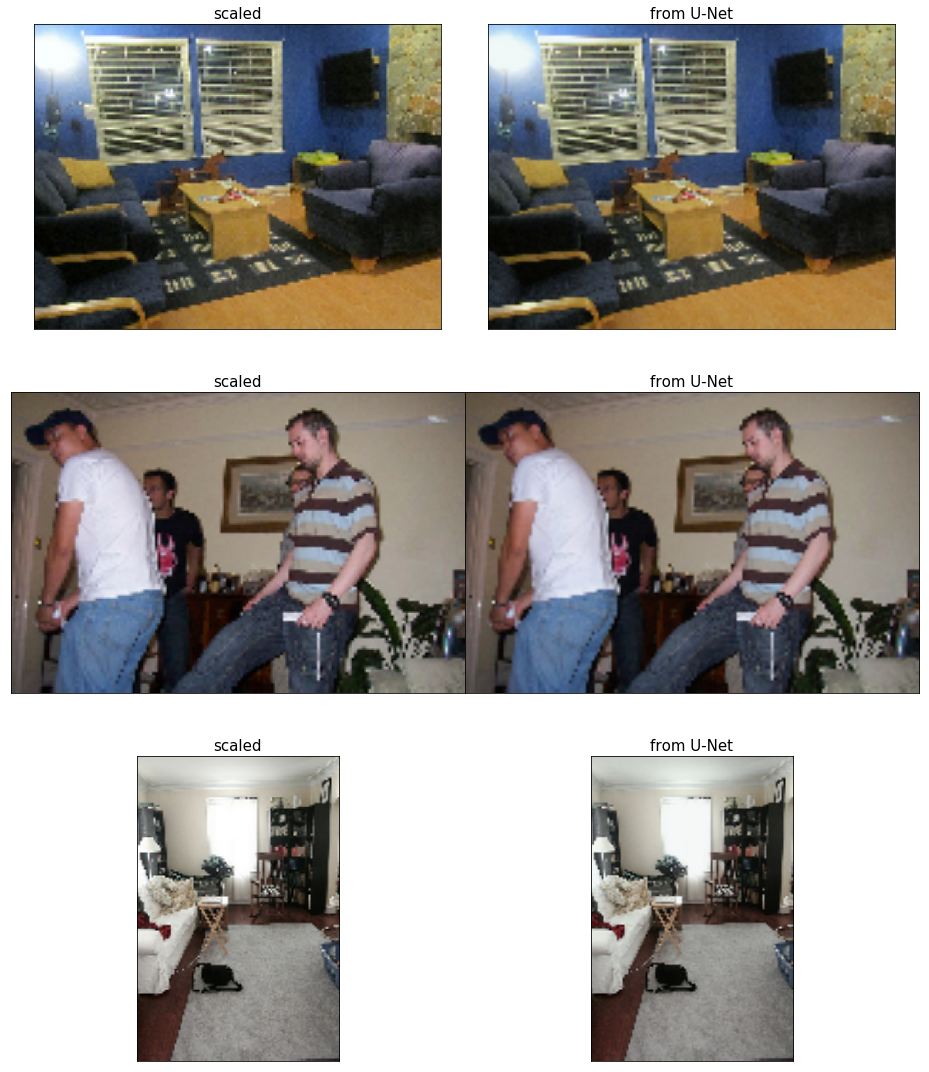

In [38]:
output_samples = []
for i in range(num_show):
    # Predicting on a single input image:
    output = unet_model.predict(input_samples[i][None, ...])[0]
    output_samples.append(output)

figure = plot_image_grid([input_samples, output_samples],#, target_samples], 
                         titles=["scaled", "from U-Net", "original"])
figure.show()

The gain in image quality may seem small, but image super-resolution is a complicated task for CNNs (c.f. book).

## Conclusion

Using image super-resolution as a pretext, we got acquainted with convolutional auto-encoders, and implemented our own U-Net. In the following notebooks, we will apply this architecture (and the FCN one) to another complex task: semantic segmentation.

<a id="ref"></a>
#### References

1. Lin, T.-Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., Dollár, P., Zitnick, C.L., 2014. Microsoft coco: Common objects in context. In: European Conference on Computer Vision. pp. 740755.
2. Ronneberger, O., Fischer, P., Brox, T., 2015. U-Net: Convolutional Networks for Biomedical Image Segmentation. arXiv:1505.04597 [cs].
3. He, K., Zhang, X., Ren, S., Sun, J., 2015. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In: Proceedings of the IEEE International Conference on Computer Vision. pp. 10261034.